# Satya Signature v6

```{contents}
```

## Load Data

In [1]:
import pandas as pd

In [2]:
path= 'H:\group\Lamba Share\COMMON.FOLDER\FM_SN_Dx_lasso\Dx_Relapse_Lasso_upregulated_SN'

raw_coefs = pd.read_csv(path + '\Lasso_results_upregulated_beta.csv', index_col=0)\
    .sort_index()

df = pd.read_csv(path + '\Lasso_results_upregulated_inputfile.csv', index_col=0)\
    .sort_index()

In [3]:
# Delete 2 genes from the rows of raw_coefs: 'SLAIN1' and 'GUCD1'
raw_coefs = raw_coefs.drop(['SLAIN1', 'GUCD1'])

# Delete 2 genes from the rows of df: 'SLAIN1' and 'GUCD1'
df = df.drop(columns=['SLAIN1', 'GUCD1'])


## Perform multivariate CoxPH-Lasso

Here we will run on 167 CpGs that were selected from EWAS risk-adjusted OS at 1*10e-6 significance:

In [4]:
def set_cutoff(coefs, threshold):
    """
    Set feature inclusion threshold (only features present in [threshold]% of loops will be taken).

    Parameters:
    ----------
    coefs: object
        A dataframe containing the raw calculated coefficients. 
    threshold: float, default= 0.8
        Feature inclusion threshold (only features present in [threshold]% of loops will be taken)

    Returns:
    --------
    A dataframe containing the mean, non-zero calculated coefficients.

    """
    # Set feature inclusion threshold (only features present in 80% of loops will be taken)
    coefs2 = coefs[coefs['nonzero_freq'] > threshold].replace(
        0, np.NaN).drop(columns=['nonzero_count', 'nonzero_freq'])

    # Get the mean values of selected coefficients, ignoring 0s
    coef_mean = coefs2.mean(axis=1, skipna=True).sort_values(ascending=False)
    return (coef_mean)


def plot_nonzero_coef_freq(raw_coefs, mean_coefs, threshold=0.85, savefig=False, figsize=(12,6)):
    
    sns.set_theme(style='white')

    # Larger figure size
    fig, ax = plt.subplots(figsize=figsize)

    # Sorting the raw_coefs DataFrame by 'nonzero_freq'
    raw_coefs = raw_coefs.sort_values('nonzero_freq', ascending=False)

    # Plotting with a more pleasing color palette
    sns.barplot(x=raw_coefs.index, y=raw_coefs['nonzero_freq'], palette='viridis', ax=ax)

    # Adding y line
    plt.axhline(threshold, linestyle="--", color="red", label=f"Threshold for selection ({int(threshold*100)}%)",
                alpha=0.5)

    # Adding labels and title
    ax.set_xlabel("Genes, n=" + str(len(raw_coefs)), fontsize=11)
    ax.set_ylabel("Non-zero Coefficient Frequency", fontsize=11)

    plt.title(f'{len(mean_coefs)} Genes maintain significance in >{int(threshold*100)}% of model loops',
              pad=20)

    # Add xticks rotation
    plt.xticks(rotation=90)

    # Legend
    plt.legend()

    # Tight layout
    plt.tight_layout()

    # Saving the figure
    if savefig == True:
        plt.savefig(path + '/Non_zero_freq.png',
                    bbox_inches='tight', dpi=300)

    # Show the plot
    plt.show()


def generate_coxph_score(coef_mean, x, df, score_name, train_test='train'):
    """Generates a dataframe with score/Cox PH predictions

    Parameters:
    ----------
    coef_mean: object
        List of mean coeficients from CoxPH fit.
        Note: this value has to be a pandas series.
    df: object
        Dataframe to add your results to.
    x: object
        A dataframe of variables/features that will be used to calculate the score.
    score_name: 
        Name of your score/prediction column.
    train_test: str | float, default = 'train' 
        Use 'train' or float between 0 and 1 for cutoff percentile.
        If test, use pre-determined number for binary threshold/cutoff.
    cutoff: float, default=0.5
        Cutoff only matters if 'train' is selected in 'train_test' arg.
        cutoff is within (0,1) and defines cutoff percentile for
        categorical score.

    Returns:
    --------
        A dataframe with calculated quantitative and categorical score/model predictions
        and the value of the cutoff on the continuous variable.

    """

    # Calculate score in test(validation) data
    b = np.arange(len(coef_mean))
    df2 = pd.DataFrame()
    coef_mean = coef_mean.squeeze()  # Transforms coefs into pd.Series if pd.DataFrame

    for i in b:
        df2['coef_' + str(i)] = x[coef_mean.index[i]
                                  ].apply(lambda x: x * coef_mean[i])

    df3 = df2.iloc[:, (df2.shape[1] - coef_mean.shape[0]):df2.shape[1]]

    # Save calculated score as a separate column of the original dataframe
    df[score_name] = df3.sum(axis=1)

    # Determine train
    if train_test == 'train':
        
        from sklearn.tree import DecisionTreeRegressor

        X = df[[score_name]]
        y = df['efs.time']

        # Build a decision tree
        tree = DecisionTreeRegressor(max_depth=1)
        tree.fit(X, y)

        # Get the threshold value for split
        i = tree.tree_.threshold[0]

    else:
        i = train_test

    print(f'Continuous score cut at the value of {round(i,4)}')

    # Binarize score
    df[score_name + ' Categorical'] = pd.cut(df[score_name],
                                             bins=[-np.inf, i, np.inf],
                                             labels=['Low', 'High'])

    df[score_name + '_cat_bin'] = pd.cut(df[score_name],
                                         bins=[-np.inf, i, np.inf],
                                         labels=[0, 1])

    return (df, i)

In [5]:
# change column `non_zero_frequency` to `nonzero_freq`
raw_coefs = raw_coefs.rename(columns={'non_zero_frequency': 'nonzero_freq', 'non_zero_counts': 'nonzero_count'})

### Set Threshold

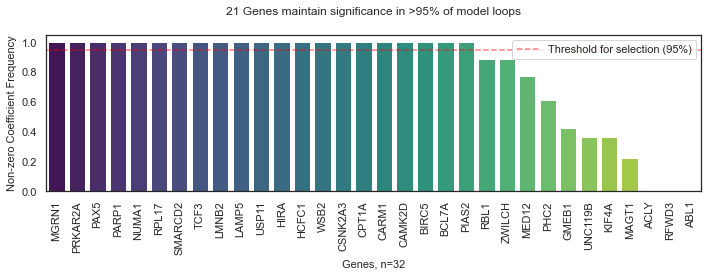

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='white')

mean_coefs = set_cutoff(coefs=raw_coefs,threshold=0.95)
                                
plot_nonzero_coef_freq(raw_coefs, mean_coefs, threshold=0.95, savefig=True, figsize=(10,4))


## Generate Model Results

### Discovery Dataset

In [8]:
df[['efs.time', 'os.time', 'efs.evnt', 'os.evnt']].describe().round(2)

,efs.time,os.time,efs.evnt,os.evnt
count,1420.00,1420.00,1420.00,1420.00
mean,2.63,3.48,0.53,0.35
std,2.27,2.20,0.50,0.48
min,0.00,0.00,0.00,0.00
25%,0.68,1.38,0.00,0.00
50%,1.73,3.42,1.00,0.00
75%,4.50,5.23,1.00,1.00
max,9.95,11.02,1.00,1.00


In [9]:
score_name = 'Relapse_Score_21'

# Find columns in `df` that are in `mean_coefs.index`
cols_of_interest = df.columns[df.columns.isin(mean_coefs.index)]
gene_expression_matrix = df[cols_of_interest]

In [10]:
#sort column order by mean_coefs
gene_expression_matrix = gene_expression_matrix[mean_coefs.index]

In [11]:
df, threshold = generate_coxph_score(coef_mean=mean_coefs,
                                        x=gene_expression_matrix,
                                        df=df,
                                        score_name=score_name,
                                        train_test="train")

Continuous score cut at the value of -2.8505


## Kaplan-Meier Plots

In [12]:
def draw_kaplan_meier(scorename, df, save_plot=False,
                      add_risk_counts=False, save_survival_table=False,
                      trialname=None, show_ci=False):
    """
    Returns a Kaplan-Meier plot with:

        1. Hazard Ratio
        2. P-value
        3. Risk counts
        4. Survival table

    Parameters:
    ----------
    scorename: str
        Name of your model (and a column in df).
    df: object
        A dataframe containing:
            1. Continuous predictions of Cox Regression model under "scorename".
            2. efs/os information in the format of "efs.time" and "efs.evnt".
    save_plot: bool, default=False
        Set to True if you wish to save the plot.It will be saved under "../Figures/ForestPlot/"
    trialname: str
        Name of your clinical trial or dataset.
    scorename: str
        Name of your model.

    Returns:
    --------
        A magnificent double kaplan-meier figure.

    """
    # Import libraries for Kaplan Meier
    from lifelines.plotting import add_at_risk_counts
    from lifelines import KaplanMeierFitter
    from lifelines import CoxPHFitter

    # Set up the matplotlib figure
    sns.set_theme(style='white')
    f, ax = plt.subplots(2, 1, sharex=True, figsize=(8, 10))

    # Define survival curve categories
    groups = df[scorename + ' Categorical']
    ix = (groups == 'High')

    # Fit the Kaplan Meier to each category of groups (kmf1 and kmf2)
    def surv_curves(i, t, e):

        T = df[t]
        E = df[e]
        kmf1 = KaplanMeierFitter()
        kmf1.fit(T[~ix], E[~ix], label='Low-' + scorename + ', n=' +
                 str(len(df[df[scorename + ' Categorical'].isin(['Low'])])))
        ax = kmf1.plot_survival_function(
            ax=i, show_censors=True, ci_show=show_ci)

        kmf2 = KaplanMeierFitter()
        kmf2.fit(T[ix], E[ix], label='High-' + scorename + ', n=' +
                 str(len(df[df[scorename + ' Categorical'].isin(['High'])])))
        ax = kmf2.plot_survival_function(
            ax=i, show_censors=True, ci_show=show_ci)

        # Calculate Hazard Ratio (HZ) and p-value (p)
        X_CPH = df[[scorename + '_cat_bin', t, e]]
        cph = CoxPHFitter()
        HZ = cph.fit(X_CPH, t, event_col=e)
        hz = HZ.hazard_ratios_[0]
        p = HZ.summary['p'][0]

        # Annotate HZ and p
        i.annotate(f'Hazard Ratio: {hz:.4f}\np-value: {p:.2e}',
                   xy=(9.75, 0.085), xycoords='data',
                   ha='right', va='center', fontsize=11,
                   bbox={'boxstyle': 'round', 'facecolor': 'none',
                         'edgecolor': 'lightgray'})

        # Add risk counts below the graph
        if add_risk_counts == True:
            add_at_risk_counts(kmf1, kmf2, ax=i)

        # Save Survival Function Table
        if save_survival_table == True:
            surv1 = kmf1.survival_function_.join(kmf1.confidence_interval_)
            surv2 = kmf2.survival_function_.join(kmf2.confidence_interval_)
            surv3 = surv1.join(surv2, how='outer')
            surv3.to_csv('../Figures/Kaplan_Meiers/KM_OS_SurvivalTable_' +
                         scorename + '_' + trialname + '_' + str(len(df)) + '.csv')

        i.set_ylim(0, 1)
        i.set_ylabel("est. probability of survival $\hat{S}(t)$")

    surv_curves(i=ax[0], t='efs.time', e='efs.evnt')
    surv_curves(i=ax[1], t='os.time', e='os.evnt')

    ax[0].set_title('Event-Free Survival', loc='left',
                    pad=10, fontweight='bold')
    ax[1].set_title('Overall Survival', loc='left', pad=10, fontweight='bold')
    # Define Plot Specs
    plt.subplots_adjust(wspace=0, hspace=0.2)
    plt.suptitle("Kaplan-Meiers of " + scorename + " in " + trialname + ", n=" + str(len(df)),
                 fontsize='medium', y=0.94,
                 fontweight='bold')
    plt.xlim(0, 10)
    plt.xlabel("time $t$ (years)")

    # Save plot figure
    if save_plot == True:
        plt.savefig(path + '/Kaplan-meier_' + scorename + '_' + trialname + '_' + str(len(df)) + '.png',
                    bbox_inches='tight', dpi=300)

    return (plt.show())

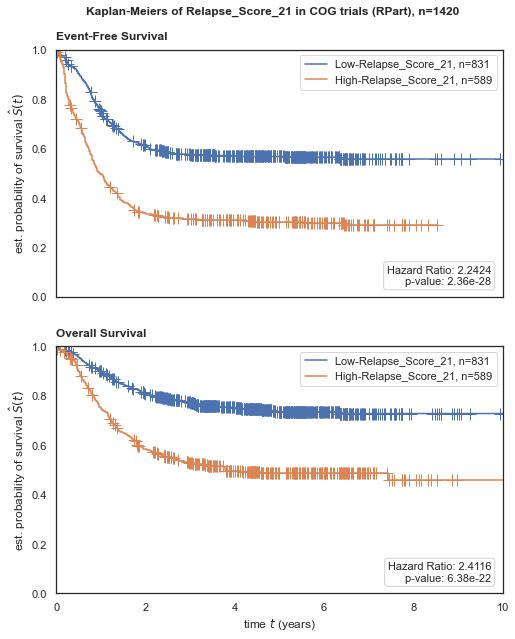

In [13]:
draw_kaplan_meier(scorename=score_name,
                        df=df,
                        save_plot=True,
                        add_risk_counts=False,
                        trialname='COG trials (RPart)')

## Plot R-Part Results

In [14]:
df[score_name].describe()

count    1420.000000
mean       -2.917982
std         0.438778
min        -4.734533
25%        -3.195871
50%        -2.928402
75%        -2.646781
max        -1.026513
Name: Relapse_Score_21, dtype: float64

In [25]:
# Identify what quantile is `threshold`
df[score_name].quantile(0.58)


-2.8569519245747013

In [26]:
threshold

-2.850469708442688

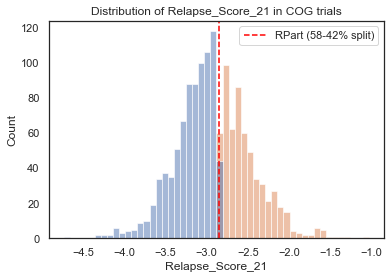

In [27]:
sns.histplot(data=df,x=score_name, bins=50, hue = score_name + ' Categorical' )

# add vertical line at threshold and third quartile
plt.axvline(threshold ,color='red', linestyle='--')

# add legend
plt.legend({'RPart (58-42% split)':threshold})
plt.title('Distribution of ' + score_name + ' in COG trials')

plt.savefig(path + '/Distribution_' + score_name + '_' + str(len(df)) + '.png',
                    bbox_inches='tight', dpi=300)
                    


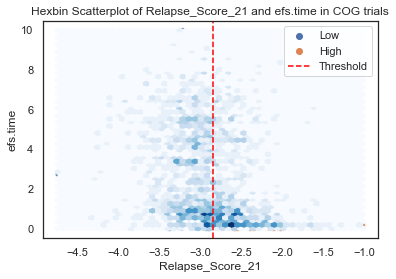

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# create scatterplot 
sns.scatterplot(data=df, x=score_name, y='efs.time', hue=score_name + ' Categorical', alpha=0.8)

# use hexbin plot to show density
ax = plt.gca()
ax.hexbin(df[score_name], df['efs.time'], gridsize=50, cmap='Blues')

# add title
plt.title('Hexbin Scatterplot of {} and efs.time in COG trials'.format(score_name)) 

# add vertical line at threshold
plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
plt.legend()

# save plot as png
plt.savefig(path + '/Hexbin_Scatterplot_{}_efs.time_{}.png'.format(score_name, len(df)), 
            bbox_inches='tight', dpi=300)

plt.show()

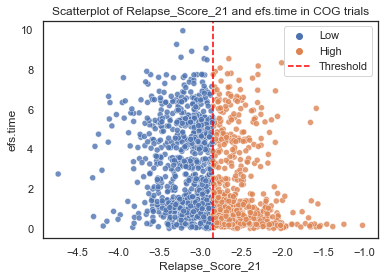

In [29]:
# create scatterplot
sns.scatterplot(data=df, x=score_name, y='efs.time', hue=score_name + ' Categorical', alpha=0.8)

# add title
plt.title('Scatterplot of ' + score_name + ' and efs.time in COG trials')

# add vertical line at threshold
plt.axvline(threshold ,color='red', linestyle='--', label='Threshold')
plt.legend()

# save plot as png
plt.savefig(path + '/Scatterplot_' + score_name + '_efs.time_' + str(len(df)) + '.png',
                    bbox_inches='tight', dpi=300)

plt.show()


In [30]:
mean_coefs

Gene
CARM1      0.303868
LMNB2      0.276869
BCL7A      0.189475
CPT1A      0.156482
USP11      0.144680
BIRC5      0.066606
CAMK2D     0.054130
LAMP5      0.032739
PARP1      0.028668
PIAS2     -0.039532
WSB2      -0.046007
PAX5      -0.066268
HIRA      -0.066383
SMARCD2   -0.083063
NUMA1     -0.101261
PRKAR2A   -0.116745
CSNK2A3   -0.199311
RPL17     -0.211515
MGRN1     -0.219611
TCF3      -0.308438
HCFC1     -0.392486
dtype: float64

In [32]:
# Save df
df.to_csv(path+'\LASSO_Relapse_Score_Unadjusted_Risk_upregulated_21genes_' + str(len(df)) + '.csv')

## Validation

In [67]:
path= 'H:\group\Lamba Share\COMMON.FOLDER\FM_SN_Dx_lasso\Dx_Relapse_AML02_Validation'

df_validation = pd.read_csv(path + '\AML_02_Exp_21_Relapse_Signature_input_163.csv', index_col=0)\
    .sort_index()

## Apply Model to Test Dataset

In [68]:
score_name = 'Relapse_Score_21'
# Find columns in `df_validation` that are in `mean_coefs.index`
cols_of_interest = df_validation.columns[df_validation.columns.isin(mean_coefs.index)]
gene_expression_matrix_validation = df_validation[cols_of_interest]
#sort column order by mean_coefs
gene_expression_matrix_validation = gene_expression_matrix_validation[mean_coefs.index]

In [81]:
df_validation2, threshold = generate_coxph_score(coef_mean=mean_coefs,
                                        x=gene_expression_matrix_validation,
                                        df=df_validation,
                                        score_name=score_name,
                                        train_test='train')

Continuous score cut at the value of -0.9745


## Plot R-Part Results

In [82]:
df_validation2[score_name].quantile(0.60)

-1.1487626247927278

Text(0.5, 1.0, 'Distribution of Relapse_Score_21 in COG trials')

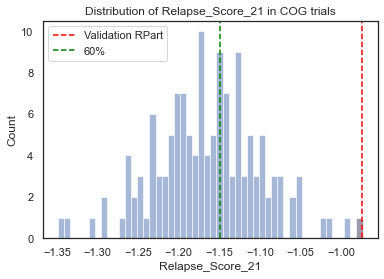

In [91]:
sns.histplot(data=df_validation2,x=score_name, bins=50, hue = score_name + ' Categorical' )

# add vertical line at threshold and third quartile
plt.axvline(threshold ,color='red', linestyle='--')
# Add another line at 60% 
plt.axvline(df_validation2[score_name].quantile(0.60) ,color='green', linestyle='--')

# add legend
plt.legend({'Validation RPart':threshold, '60%':df_validation2[score_name].quantile(0.60)})

plt.title('Distribution of ' + score_name + ' in COG trials')

# plt.savefig(path + '/Distribution_' + score_name + '_' + str(len(df_validation)) + '.png',
#                     bbox_inches='tight', dpi=300)
                

## Kaplan-Meier Plots

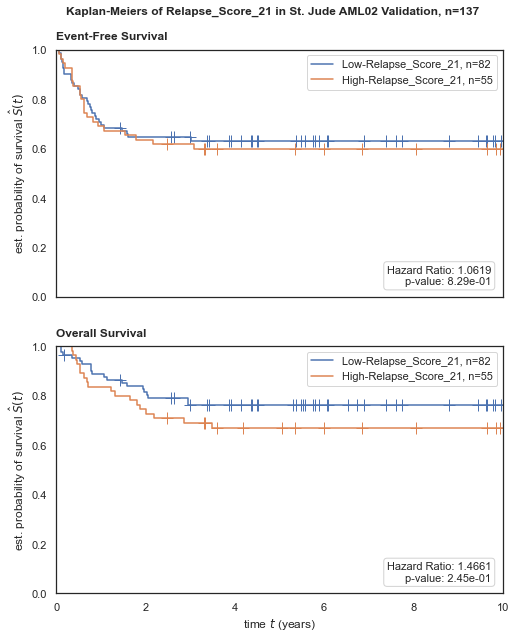

In [80]:
draw_kaplan_meier(scorename=score_name,
                        df=df_validation2,
                        save_plot=True,
                        add_risk_counts=False,
                        trialname='St. Jude AML02 Validation')

## Watermark

In [40]:
%load_ext watermark

In [42]:
# watermark with all libraries used in this notebook
%watermark -v -p pandas,seaborn,matplotlib,tableone,sklearn,lifelines,statannotations -a Francisco_Marchi_Satya_Nittu@Lamba_Lab_UF -d -m

Author: Francisco_Marchi_Satya_Nittu@Lamba_Lab_UF

Python implementation: CPython
Python version       : 3.10.10
IPython version      : 8.3.0

pandas         : 1.5.3
seaborn        : 0.12.2
matplotlib     : 3.7.1
tableone       : 0.7.12
sklearn        : 0.0.post1
lifelines      : 0.27.4
statannotations: 0.5.0

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 140 Stepping 1, GenuineIntel
CPU cores   : 8
Architecture: 64bit

